### Imports

In [12]:
import pandas as pd
import pm4py

import itertools
from itertools import chain
from itertools import pairwise
from collections import Counter, ChainMap
import pygraphviz as pgv
from IPython.display import Image, display

### Data loading and formatting

In [13]:
log_small_data = pm4py.format_dataframe(pd.read_csv("../data/flight_event_log.csv", sep=','), case_id='Flight', activity_key='Activity', timestamp_key='Timestamp')

log_medium_data = pm4py.format_dataframe(pd.read_csv("../data/p2p_event_log.csv", sep=','), case_id='Case ID', activity_key='ACTIVITY', timestamp_key='EVENTTIME')

log_big_data = pm4py.format_dataframe(pd.read_csv("../data/teleclaims.csv", sep=','), case_id='Case ID', activity_key='Activity', timestamp_key='Complete Timestamp')

### Grouping

In [14]:
log_small_data['Timestamp'] = pd.to_datetime(log_small_data['Timestamp'])

log_small_data_routes = (log_small_data
                         .sort_values(by=['Flight', 'Timestamp'])
                         .groupby(['Flight'])
                         .agg({'Activity': ';'.join})
                         )

log_small_data_routes['count'] = 0
log_small_data_routes = (log_small_data_routes.groupby('Activity', as_index=False)
                         .count()
                         .sort_values(['count'], ascending=False)
                         .reset_index(drop=True)
                         )

In [15]:
log_medium_data['EVENTTIME'] = pd.to_datetime(log_medium_data['EVENTTIME'])

log_medium_data_routes = (log_medium_data
                          .sort_values(by=['Case ID', 'EVENTTIME'])
                          .groupby('Case ID', as_index=False)
                          .agg({'ACTIVITY': ';'.join}))

log_medium_data_routes['count'] = 1
log_medium_data_routes = (log_medium_data_routes.groupby('ACTIVITY', as_index=False)
                          .agg({'count': 'sum'})
                          .sort_values(by='count', ascending=False)
                          .reset_index(drop=True))

In [16]:
log_big_data['Complete Timestamp'] = pd.to_datetime(log_big_data['Complete Timestamp'])

log_sorted = log_big_data.sort_values(by=['Case ID', 'Complete Timestamp'])

log_big_data_routes = (log_sorted
                       .groupby('Case ID', as_index=False)
                       .agg({'Activity': ';'.join}))

log_big_data_routes['count'] = 1
log_big_data_routes = (log_big_data_routes.groupby('Activity', as_index=False)
                       .agg({'count': 'sum'})
                       .sort_values(by='count', ascending=False)
                       .reset_index(drop=True))

### Direct follow graph

Defines functions for drawing simple DFG

In [17]:
def draw_graph_small(log):
    log['trace'] = [trace.split(';') for trace in log['Activity']]

    w_net = dict()
    for index, row in log[['trace', 'count']].iterrows():
        for ev_i, ev_j in pairwise(row['trace']):
            if ev_i not in w_net.keys():
                w_net[ev_i] = Counter()
            w_net[ev_i][ev_j] += row['count']

    G = pgv.AGraph(strict=False, directed=True)
    G.graph_attr['rankdir'] = 'LR'
    G.node_attr['shape'] = 'Mrecord'
    for event, successors in w_net.items():
        G.add_node(event, style="rounded,filled", fillcolor="#ffffcc")
        for succ, weight in successors.items():
            G.add_edge(event, succ, label=str(weight))
    G.draw('solution.png', prog='dot')
    display(Image('solution.png'))

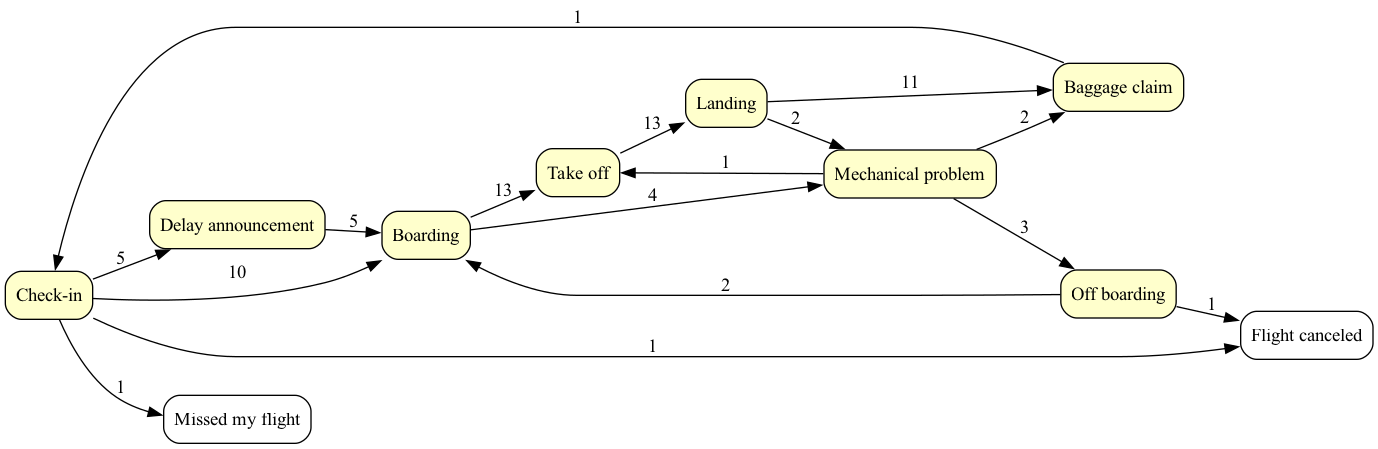

In [18]:
draw_graph_small(log_small_data_routes)

In [19]:
def draw_graph_medium(log):
    log['trace'] = [trace.split(';') for trace in log['ACTIVITY']]

    w_net = dict()
    for index, row in log[['trace', 'count']].iterrows():
        for ev_i, ev_j in pairwise(row['trace']):
            if ev_i not in w_net.keys():
                w_net[ev_i] = Counter()
            w_net[ev_i][ev_j] += row['count']

    G = pgv.AGraph(strict=False, directed=True)
    G.graph_attr['rankdir'] = 'LR'
    G.node_attr['shape'] = 'Mrecord'
    for event, successors in w_net.items():
        G.add_node(event, style="rounded,filled", fillcolor="#ffffcc")
        for sc, weight in successors.items():
            G.add_edge(event, sc, label=str(weight))
    G.draw('solution.png', prog='dot')
    display(Image('solution.png'))

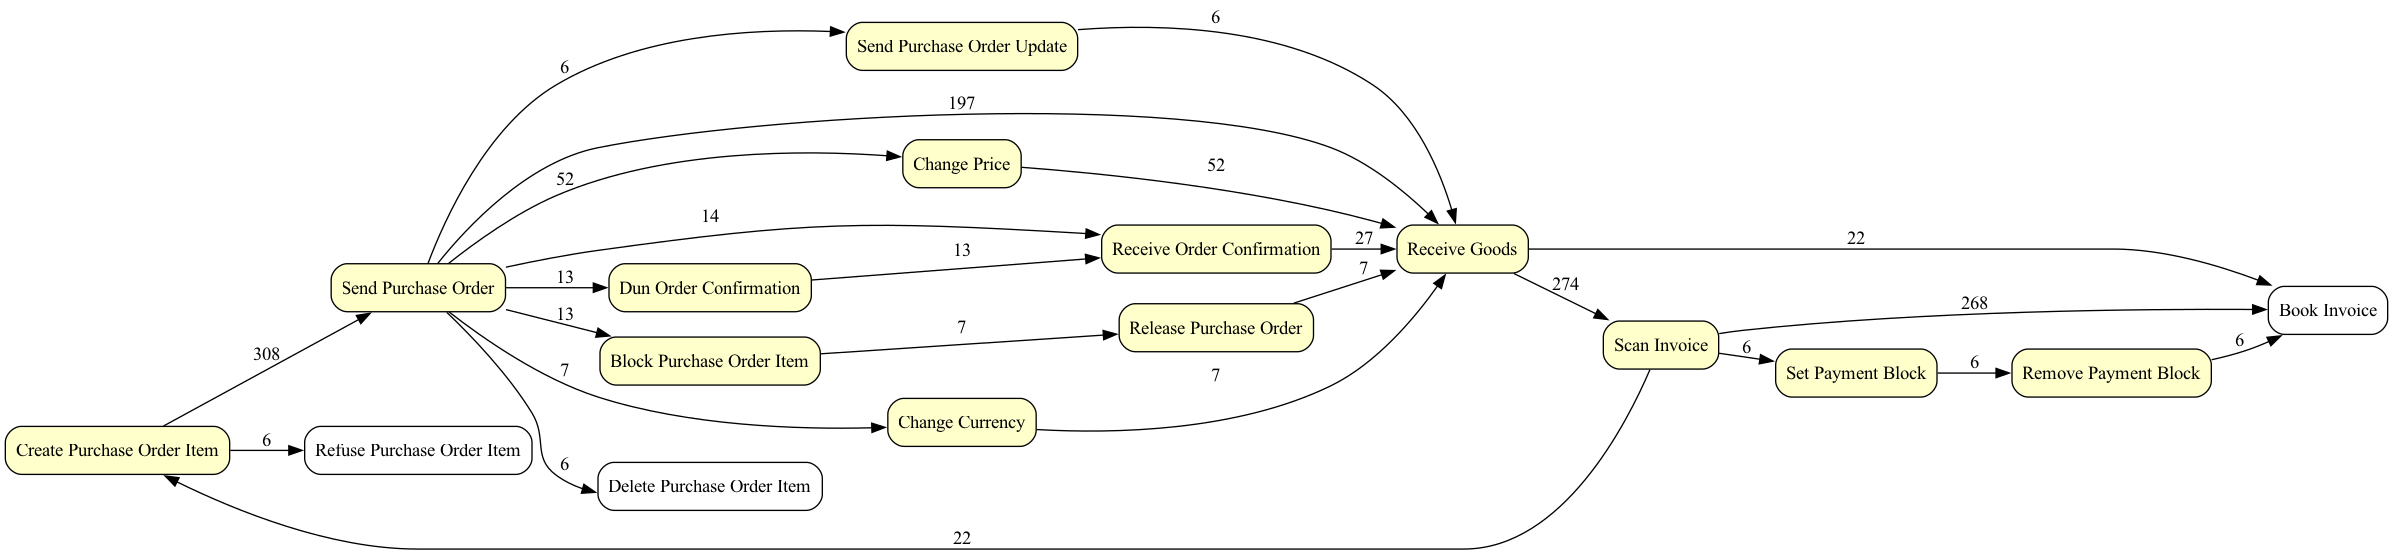

In [20]:
draw_graph_medium(log_medium_data_routes)

In [21]:
def draw_graph_big(log):
    if not isinstance(log, pd.DataFrame):
        raise ValueError("Input log must be a pandas DataFrame")
    
    log['trace'] = log['Activity'].apply(lambda x: x.split(';'))

    w_net = {}
    ev_start_set, ev_end_set = set(), set()

    for trace, count in zip(log['trace'], log['count']):
        ev_start_set.add(trace[0])
        ev_end_set.add(trace[-1])
        for ev_i, ev_j in itertools.pairwise(trace):
            if ev_i not in w_net:
                w_net[ev_i] = Counter()
            w_net[ev_i][ev_j] += count

    G = pgv.AGraph(strict=False, directed=True)
    G.graph_attr['rankdir'] = 'LR'
    G.node_attr['shape'] = 'Mrecord'

    for event, successors in w_net.items():
        G.add_node(event, style="rounded,filled", fillcolor="#ffffcc")
        for successor, weight in successors.items():
            G.add_edge(event, successor, label=str(weight))

    image_path = 'solution.png'
    G.draw(image_path, prog='dot')
    display(Image(image_path))

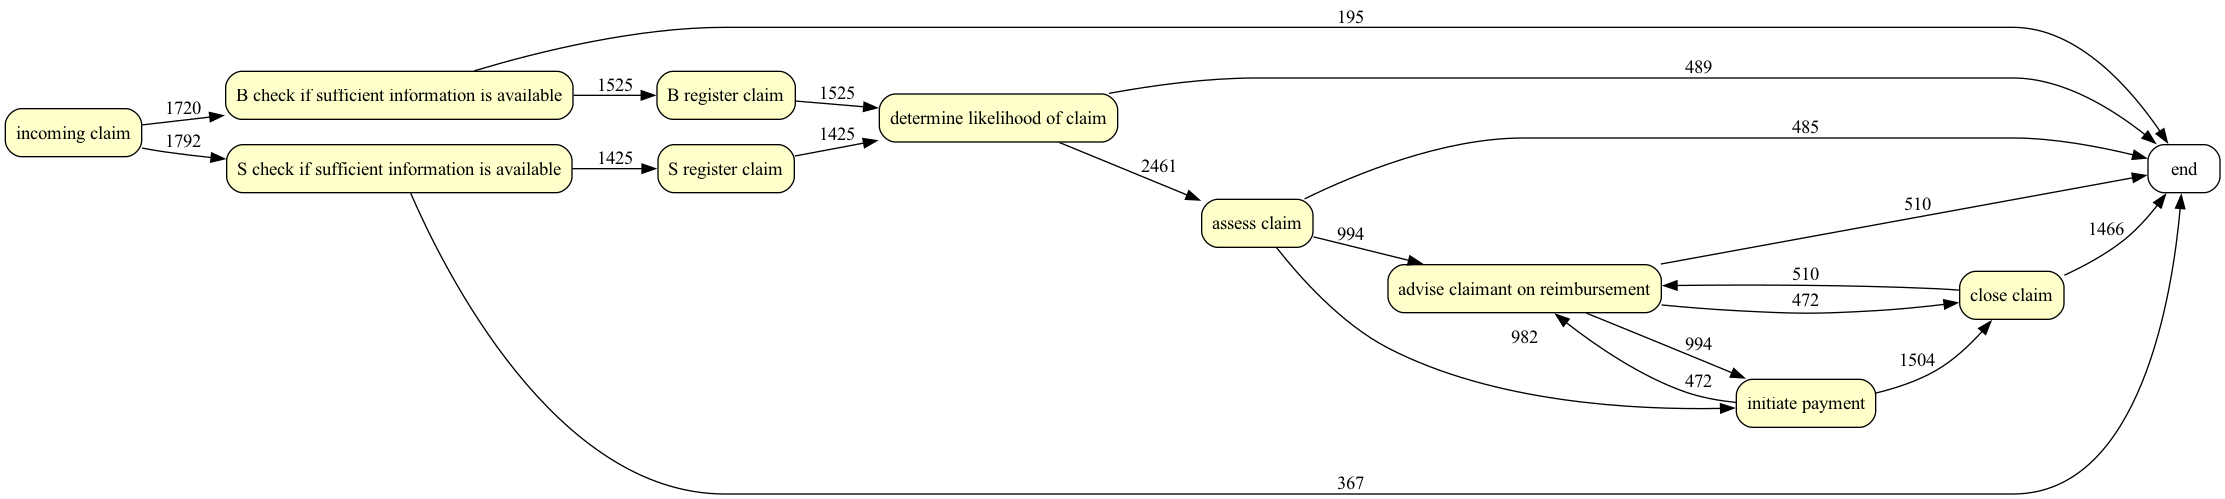

In [22]:
draw_graph_big(log_big_data_routes)

### DFG

Defines functions for more complex drawing with nodes coloring and weights

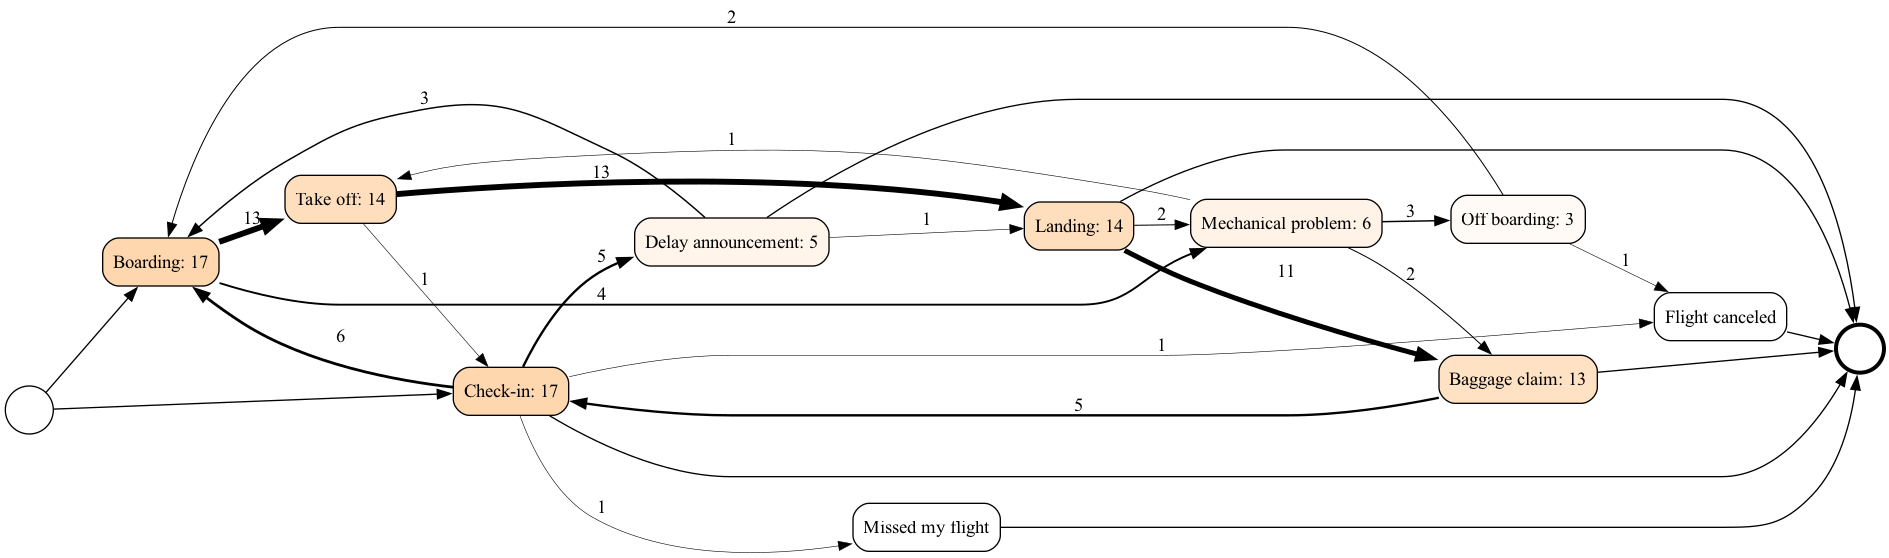

In [24]:
def draw_graph_small(dfs, flight='Flight', timestamp='Timestamp', activity='Activity'):
    ev_counter = dfs[activity].value_counts()

    dfs = (dfs
           .sort_values(by=[flight, timestamp])
           .groupby([flight])
           .agg({activity: ';'.join})
           )
    dfs['count'] = 0
    dfs = (dfs.groupby(activity, as_index=False).count()
           .sort_values(['count'], ascending=False)
           .reset_index(drop=True))

    dfs['trace'] = [trace.split(';') for trace in dfs[activity]]

    w_net = dict()
    ev_start_set = set()
    ev_end_set = set()
    for index, row in dfs[['trace', 'count']].iterrows():
        if row['trace'][0] not in ev_start_set:
            ev_start_set.add(row['trace'][0])
        if row['trace'][-1] not in ev_end_set:
            ev_end_set.add(row['trace'][-1])
        for ev_i, ev_j in pairwise(row['trace']):
            if ev_i not in w_net:
                w_net[ev_i] = Counter()
            w_net[ev_i][ev_j] += row['count']

    trace_counts = sorted(chain(*[c.values() for c in w_net.values()]))
    trace_min, trace_max = trace_counts[0], trace_counts[-1]
    color_min, color_max = ev_counter.min(), ev_counter.max()

    G = pgv.AGraph(strict=False, directed=True)
    G.graph_attr['rankdir'] = 'LR'
    G.node_attr['shape'] = 'Mrecord'

    G.add_node("start", shape="circle", label="")
    for ev_start in ev_start_set:
        G.add_edge("start", ev_start)
    G.add_node("end", shape="circle", label="", penwidth='3')
    for ev_end in ev_end_set:
        G.add_edge(ev_end, "end")

    for event, successors in w_net.items():
        value = ev_counter[event]
        color = int(float(color_min - value) / float(color_min - color_max) * 100.00)
        label = f"{event}: {ev_counter[event]}"
        my_color = "#ff9933" + str(hex(color))[2:]
        G.add_node(event, style="rounded,filled", fillcolor=my_color, label=label)
        for successor, cnt in successors.items():
            G.add_edge(event, successor, penwidth=4 * cnt / (trace_max - trace_min) + 0.1, label=cnt)

    output_file = 'solution.png'
    G.draw(output_file, prog='dot')
    display(Image(output_file))

df = pd.read_csv('../data/flight_event_log.csv')

draw_graph_small(df)

In [25]:
def draw_graph_medium(dfs, case_id, timestamp, activity):
    ev_counter = dfs[activity].value_counts()

    dfs = (dfs.sort_values(by=[case_id, timestamp])
           .groupby([case_id])
           .agg({activity: ';'.join}))
    dfs['count'] = 0
    dfs = (dfs.groupby(activity, as_index=False)
           .count()
           .sort_values(['count'], ascending=False)
           .reset_index(drop=True))
    dfs['trace'] = [trace.split(';') for trace in dfs[activity]]

    w_net = dict()
    ev_start_set = set()
    ev_end_set = set()
    for index, row in dfs[['trace', 'count']].iterrows():
        if row['trace'][0] not in ev_start_set:
            ev_start_set.add(row['trace'][0])
        if row['trace'][-1] not in ev_end_set:
            ev_end_set.add(row['trace'][-1])
        for ev_i, ev_j in pairwise(row['trace']):
            if ev_i not in w_net.keys():
                w_net[ev_i] = Counter()
            w_net[ev_i][ev_j] += row['count']

    trace_counts = sorted(chain(*[c.values() for c in w_net.values()]))
    trace_min = trace_counts[0]
    trace_max = trace_counts[-1]
    color_min = ev_counter.min()
    color_max = ev_counter.max()

    G = pgv.AGraph(strict=False, directed=True)
    G.graph_attr['rankdir'] = 'LR'
    G.node_attr['shape'] = 'Mrecord'

    G.add_node("start", shape="circle", label="")
    for ev_start in ev_start_set:
        G.add_edge("start", ev_start)

    for event, successors in w_net.items():
        value = ev_counter[event]
        color = int(float(color_min - value) / float(color_min - color_max) * 100.00)
        label = f"{event}: {ev_counter[event]}"
        my_color = f"#ff9933{hex(color)[2:]}"
        G.add_node(event, style="rounded,filled", fillcolor=my_color, label=label)
        for successor, cnt in successors.items():
            G.add_edge(event, successor, penwidth=4 * cnt / (trace_max - trace_min) + 0.1, label=cnt)

    G.add_node("end", shape="circle", label="", penwidth='3')
    for ev_end in ev_end_set:
        G.add_edge(ev_end, "end")

    G.draw('solution.png', prog='dot')
    display(Image('solution.png'))

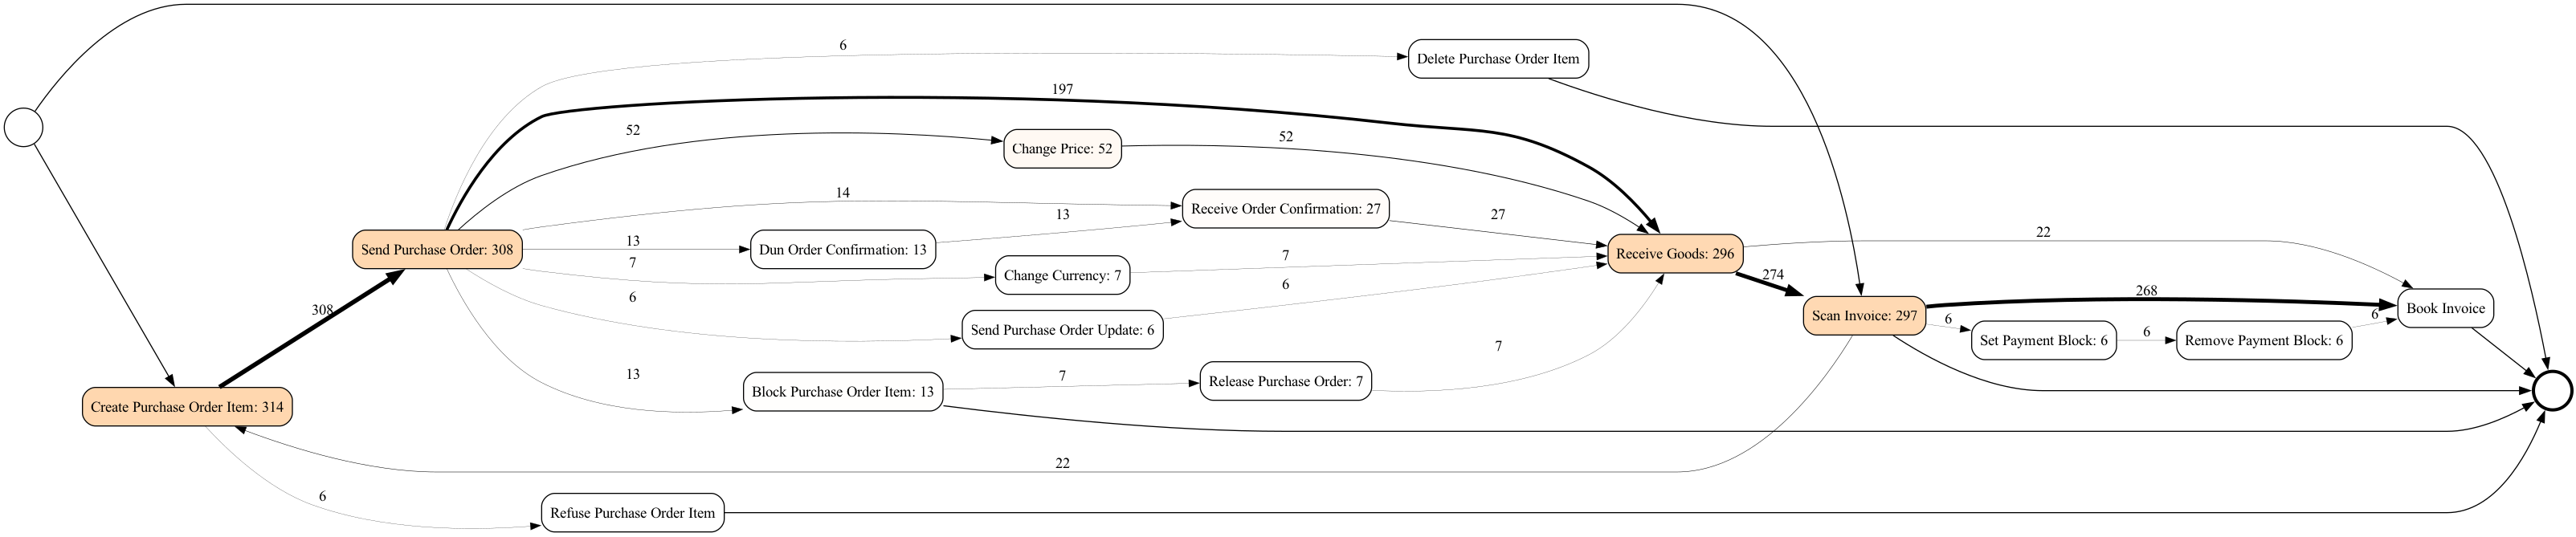

In [26]:
draw_graph_medium(log_medium_data, 'Case ID', 'EVENTTIME', 'ACTIVITY')

In [27]:
def draw_graph_big(dfs, case_id='Case ID', timestamp='Complete Timestamp', activity='Activity'):
    if not isinstance(dfs, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")

    ev_counter = dfs[activity].value_counts()

    dfs = (dfs.sort_values(by=[case_id, timestamp])
           .groupby(case_id)
           .agg({activity: ';'.join}))
    dfs['count'] = 0
    dfs = (dfs.groupby(activity, as_index=False)
           .count()
           .sort_values('count', ascending=False)
           .reset_index(drop=True))
    dfs['trace'] = dfs[activity].apply(lambda x: x.split(';'))

    w_net = {}
    ev_start_set, ev_end_set = set(), set()
    for trace, count in zip(dfs['trace'], dfs['count']):
        ev_start_set.add(trace[0])
        ev_end_set.add(trace[-1])
        for ev_i, ev_j in itertools.pairwise(trace):
            w_net.setdefault(ev_i, Counter())[ev_j] += count

    trace_counts = sorted(ChainMap(*w_net.values()).values())
    trace_min, trace_max = trace_counts[0], trace_counts[-1]
    color_min, color_max = ev_counter.min(), ev_counter.max()

    # Creating the graph
    G = pgv.AGraph(strict=False, directed=True)
    G.graph_attr['rankdir'] = 'LR'
    G.node_attr['shape'] = 'Mrecord'

    G.add_node("start", shape="circle", label="")
    G.add_node("end", shape="circle", label="", penwidth='3')

    for event, successors in w_net.items():
        value = ev_counter[event]
        color = int((color_min - value) / (color_min - color_max) * 100.00)
        label = f"{event}: {value}"
        node_color = f"#ff9933{hex(color)[2:]}"
        G.add_node(event, style="rounded,filled", fillcolor=node_color, label=label)
        for successor, count in successors.items():
            edge_width = 4 * count / (trace_max - trace_min) + 0.1
            G.add_edge(event, successor, penwidth=edge_width, label=count)

    for ev_start in ev_start_set:
        G.add_edge("start", ev_start)
    for ev_end in ev_end_set:
        G.add_edge(ev_end, "end")

    filename = 'solution.png'
    G.draw(filename, prog='dot')
    display(Image(filename))

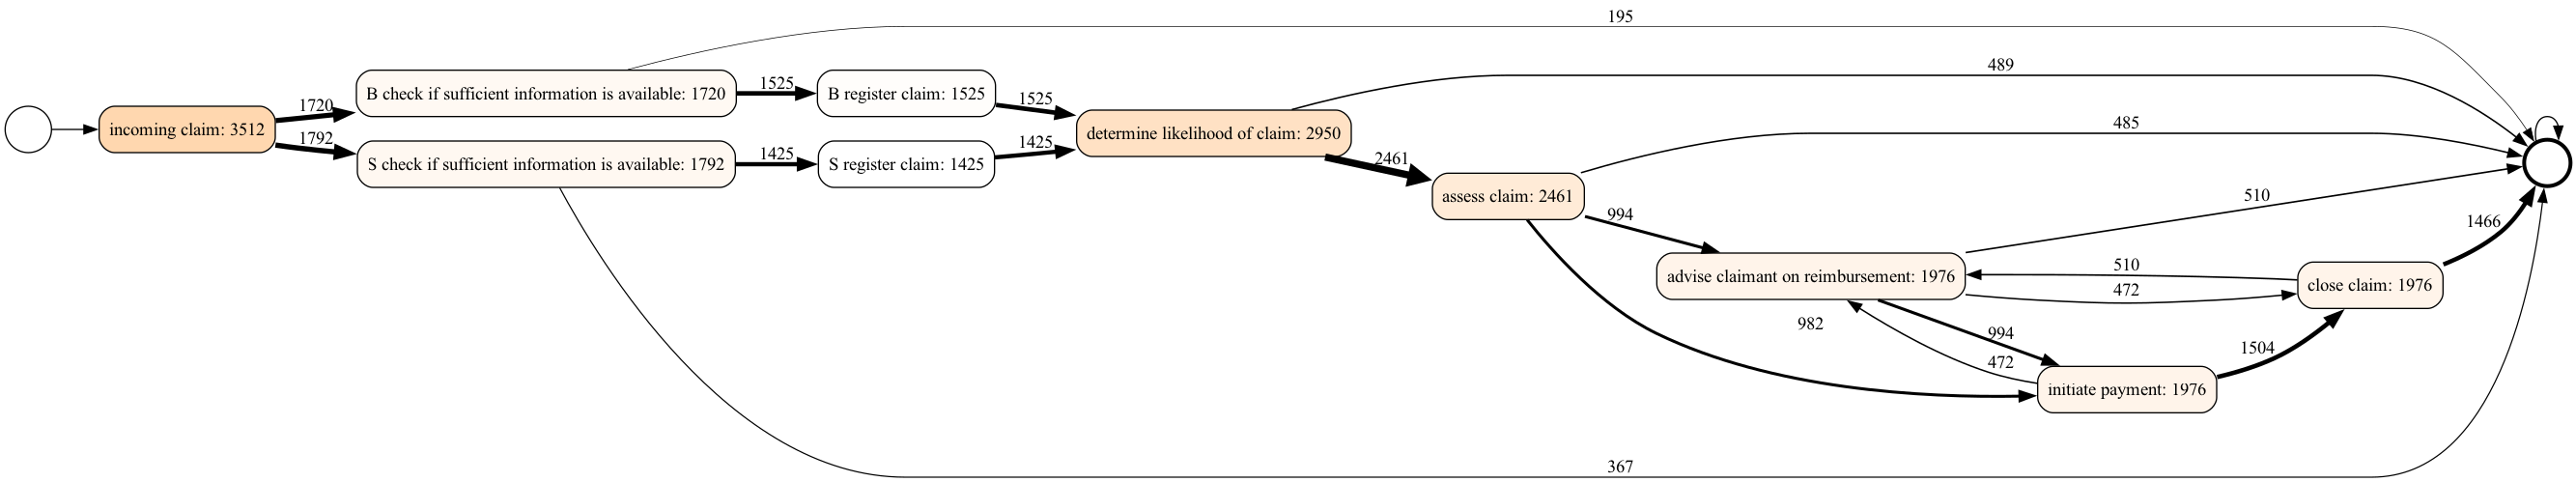

In [28]:
draw_graph_big(log_big_data)

### PM4OY

### Alpha Miner

Calls AM and shows Petri Nets

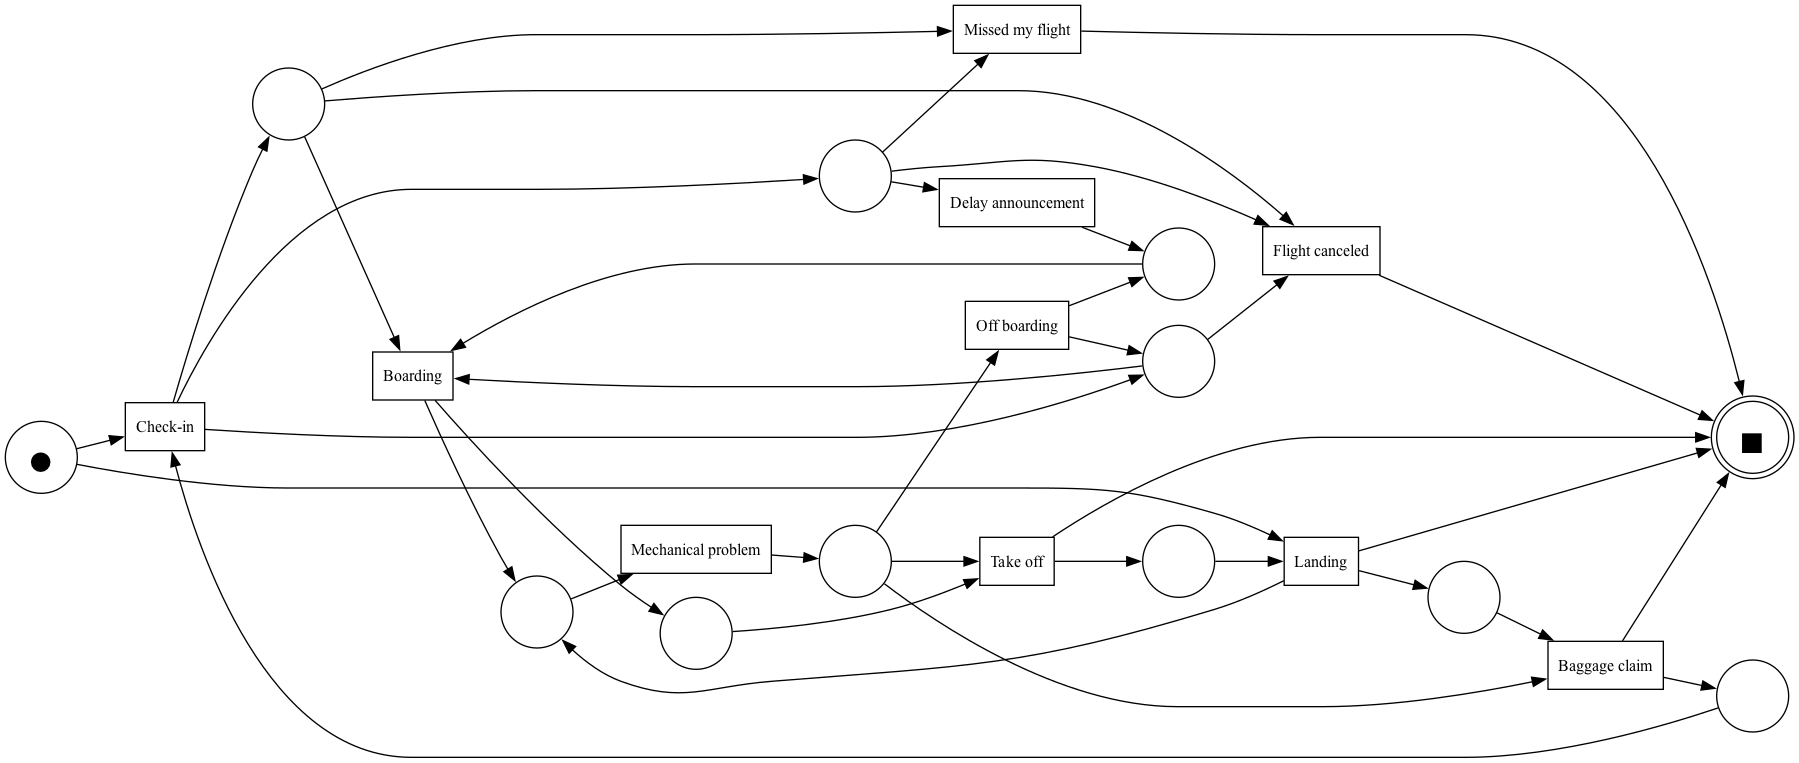

In [29]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log_small_data)

pm4py.view_petri_net(net, initial_marking, final_marking, format="png")

In [30]:
try:
    tree = pm4py.convert_to_process_tree(net, initial_marking, final_marking)
    pm4py.view_process_tree(tree)
except ValueError:
    print("Parsing of WF-net Failed")

Parsing of WF-net Failed


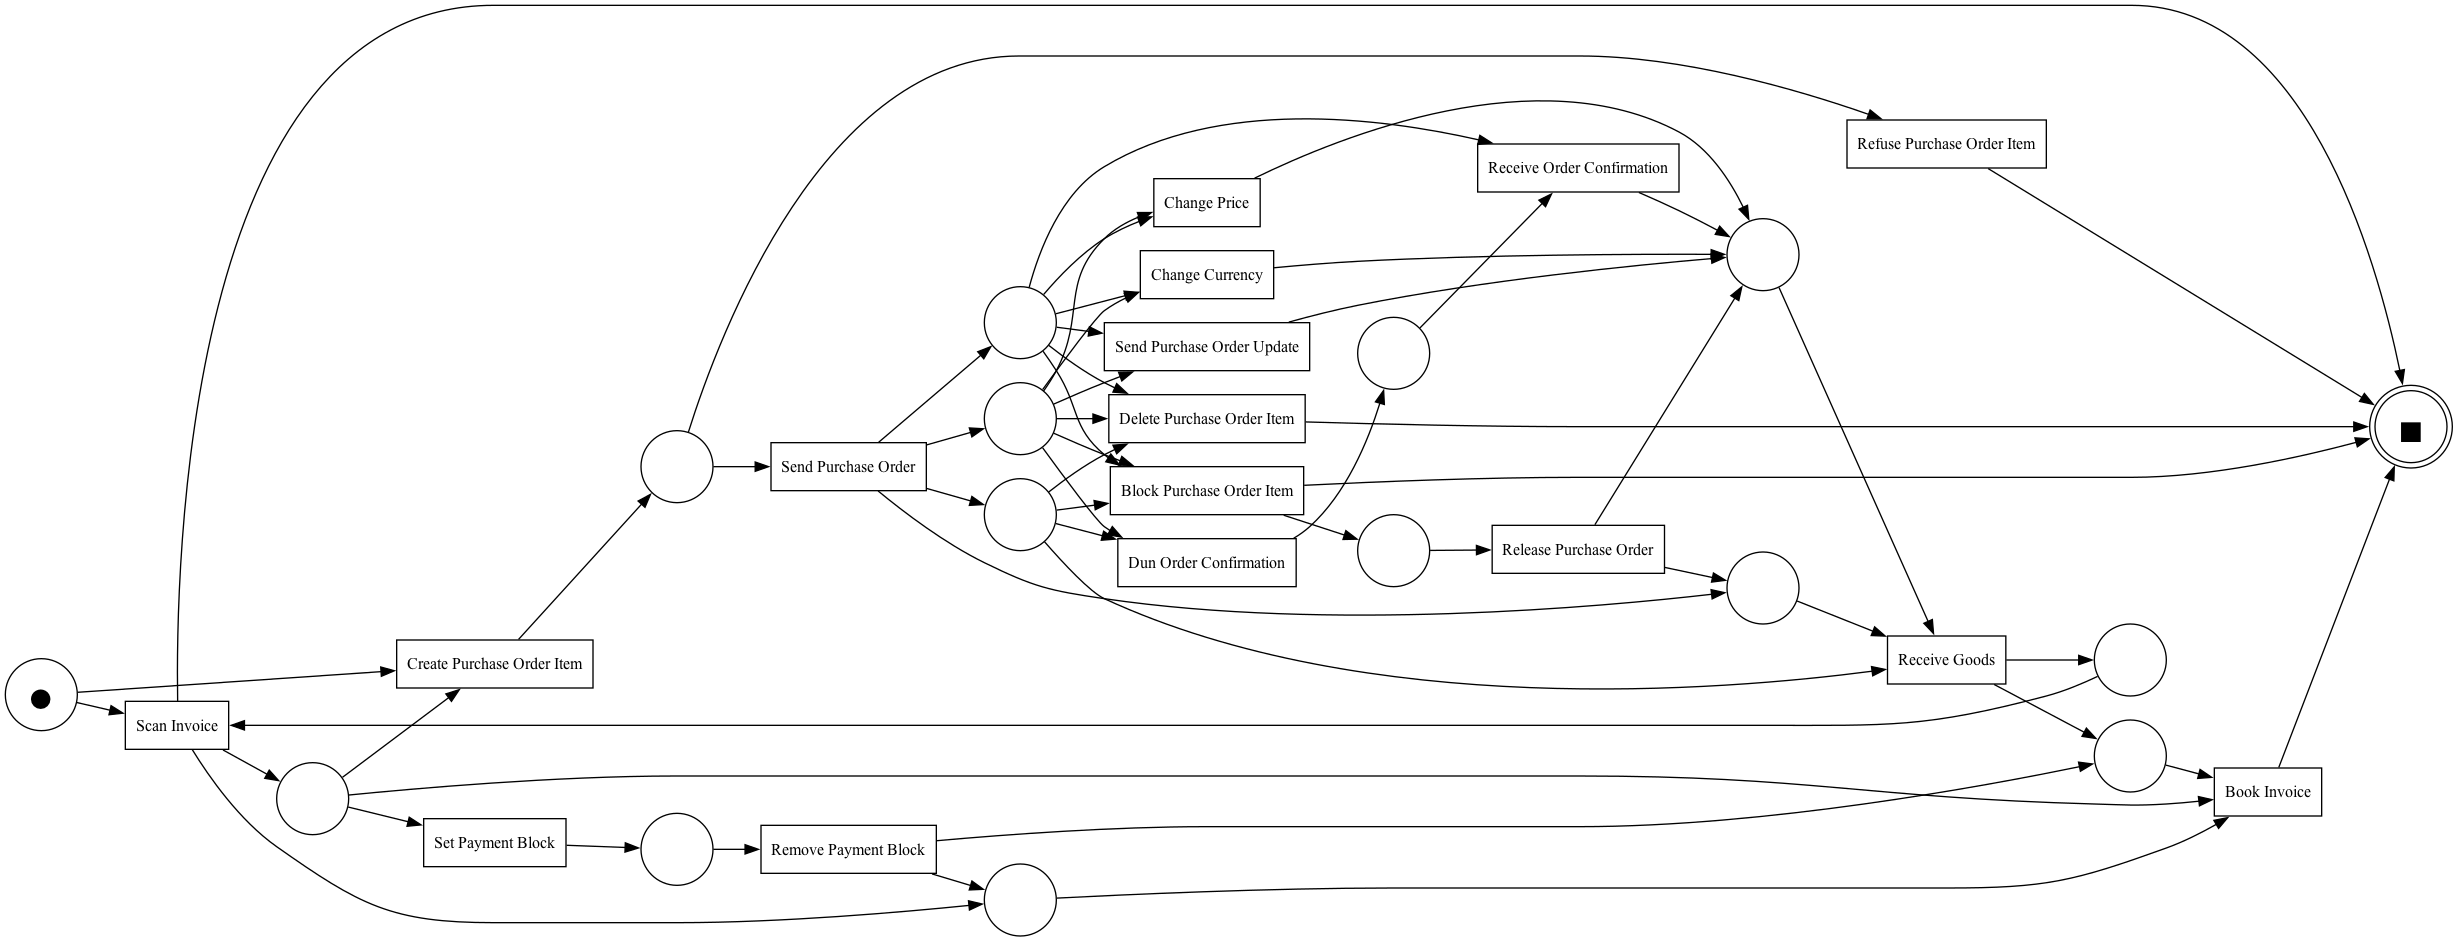

In [31]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log_medium_data)

pm4py.view_petri_net(net, initial_marking, final_marking, format="png")

In [32]:
try:
    tree = pm4py.convert_to_process_tree(net, initial_marking, final_marking)
    pm4py.view_process_tree(tree)
except ValueError:
    print("Parsing of WF-net Failed")

Parsing of WF-net Failed


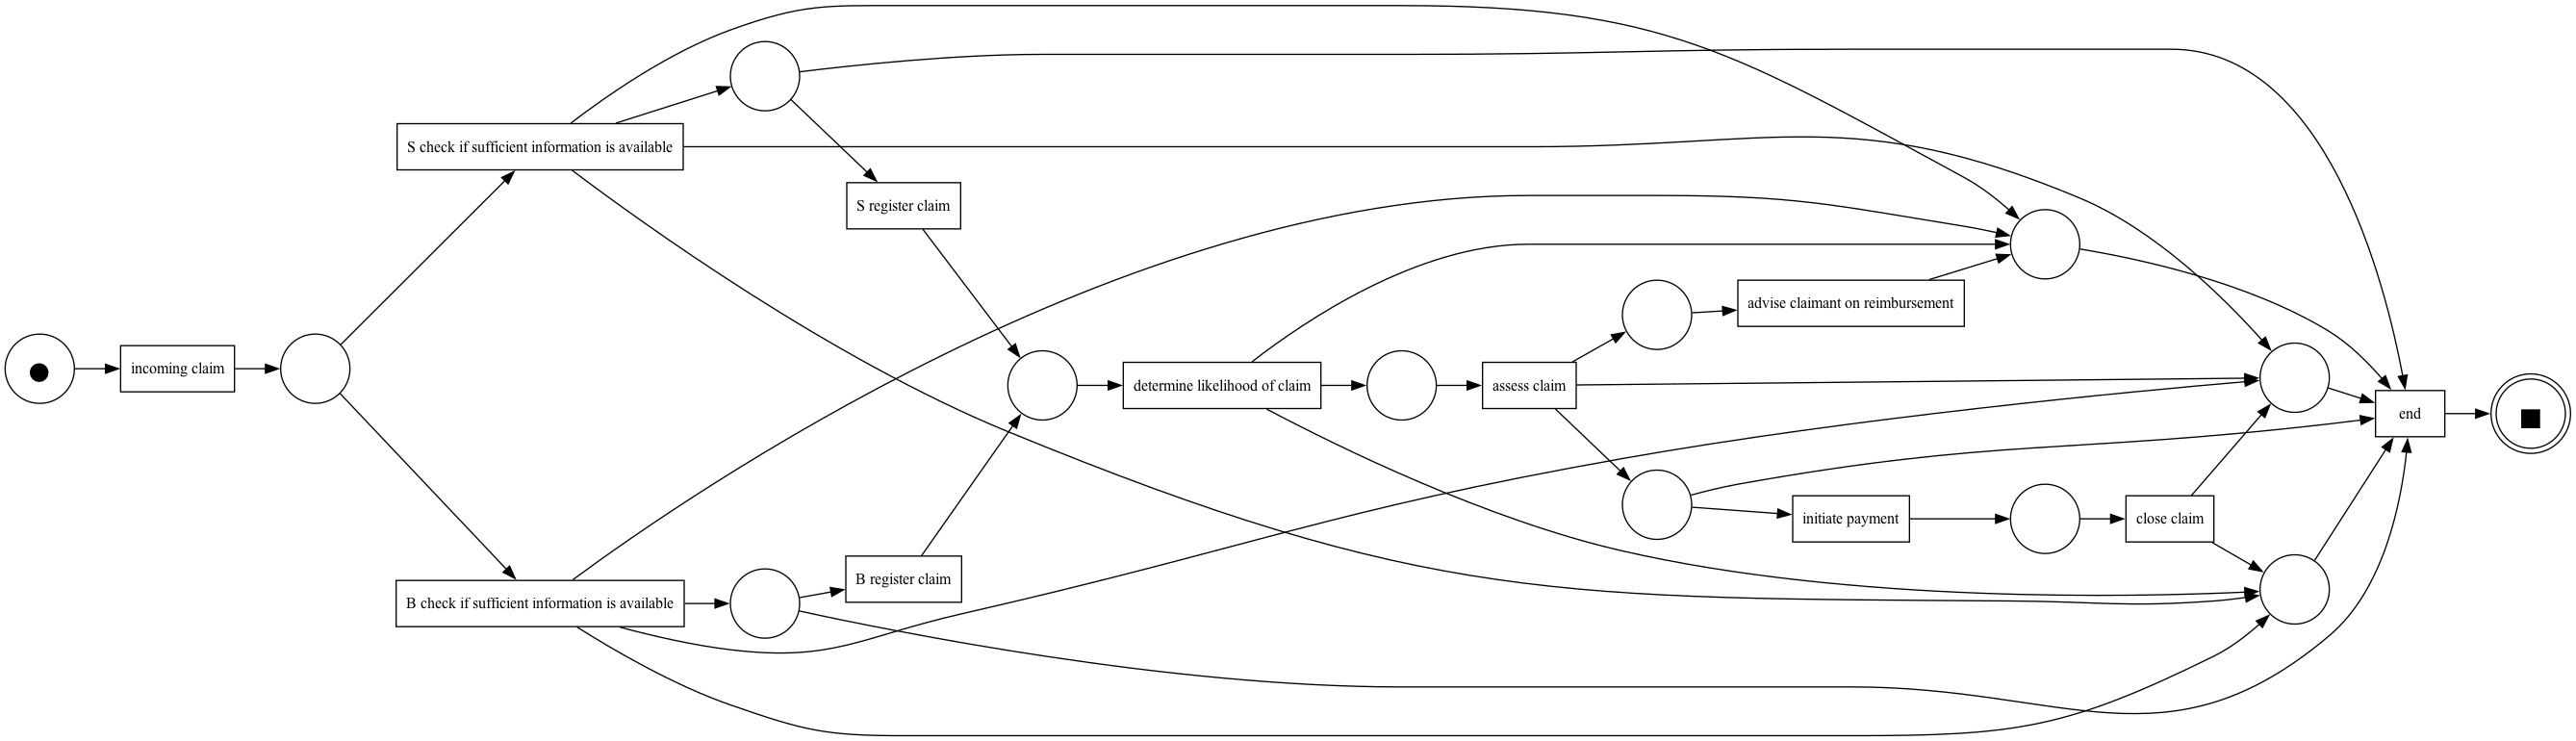

In [33]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log_big_data)

pm4py.view_petri_net(net, initial_marking, final_marking, format="png")

In [34]:
try:
    tree = pm4py.convert_to_process_tree(net, initial_marking, final_marking)
    pm4py.view_process_tree(tree)
except ValueError:
    print("Parsing of WF-net Failed")

Parsing of WF-net Failed
